<img src="https://assets.neurosurgicalatlas.com/aaroncohen-gadol-com/patients/brain-tumor-fig1.jpg" alt="Brain" style="width: 800px;">

A brain tumor is an abnormal growth of cells within the brain. It can be benign (non-cancerous) or malignant (cancerous), and it can originate within the brain (primary tumor) or spread from other parts of the body (metastatic tumor). Brain tumors can interfere with normal brain function, leading to various neurological symptoms.

Magnetic Resonance Imaging (MRI) is a powerful medical imaging technique used to identify and diagnose brain tumors. MRI uses a strong magnetic field and radio waves to create detailed images of the brain's internal structures. Here's how MRI helps in identifying brain tumors:

1. **Detailed Visualization:** MRI provides high-resolution, detailed images of the brain's structures, allowing doctors to identify abnormal growths.

2. **Contrast Enhancement:** Doctors often use contrast agents (gadolinium-based) to enhance the visibility of brain structures. These agents help differentiate between normal brain tissue and tumors, as tumors often have different blood vessel patterns and blood-brain barrier characteristics.

3. **Multi-Modal Imaging:** MRI can utilize different imaging sequences (T1-weighted, T2-weighted, FLAIR, etc.) to provide complementary information about the tissue's properties. Tumors can exhibit distinct features on these sequences, aiding in their identification.

4. **Location and Size:** MRI helps determine the size, location, and shape of a brain tumor. This information is crucial for treatment planning.

5. **Surrounding Effects:** Brain tumors can cause edema (swelling) in surrounding brain tissue. MRI can visualize these changes, helping doctors understand the impact of the tumor on nearby structures.

6. **Tracking Progression:** Follow-up MRI scans allow doctors to monitor the tumor's growth or response to treatment over time.

7. **Functional MRI (fMRI):** In some cases, fMRI is used to assess brain function before surgery. It helps surgeons avoid critical areas of the brain during tumor removal.

It's important to note that MRI is just one part of the diagnostic process. Other techniques like CT scans, PET scans, and biopsy may also be used to confirm the diagnosis and provide a comprehensive understanding of the tumor's characteristics.

**As a team , here we are attempting to Automate the Tumor identifaction process and make it 200x times efficient than manual process using CNN model.**

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


In [5]:
# Define data directories and input size
train_dir = '/kaggle/input/datathon-brain-tumor-classification/Datathon-Dataset/Training'
test_dir = '/kaggle/input/datathon-brain-tumor-classification/Datathon-Dataset/Testing'
input_size = (224, 224)
batch_size = 16

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and preprocess training data
labels = ['category1_tumor', 'category2_tumor', 'category3_tumor', 'no_tumor']
image_size = (224, 224)

X_data = []
y_data = []

for label in labels:
    label_dir = os.path.join(train_dir, label)
    label_index = labels.index(label)  # Get the label index
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size)
        X_data.append(img)
        y_data.append(label_index)  # Append the label index

X_data = np.array(X_data)
y_data = np.array(y_data)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Load and preprocess test data
X_test = []
y_test = []

for label in labels:
    label_dir = os.path.join(test_dir, label)
    label_index = labels.index(label)  # Get the label index
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size)
        X_test.append(img)
        y_test.append(label_index)  # Append the label index

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 4)  # Convert to one-hot encoding


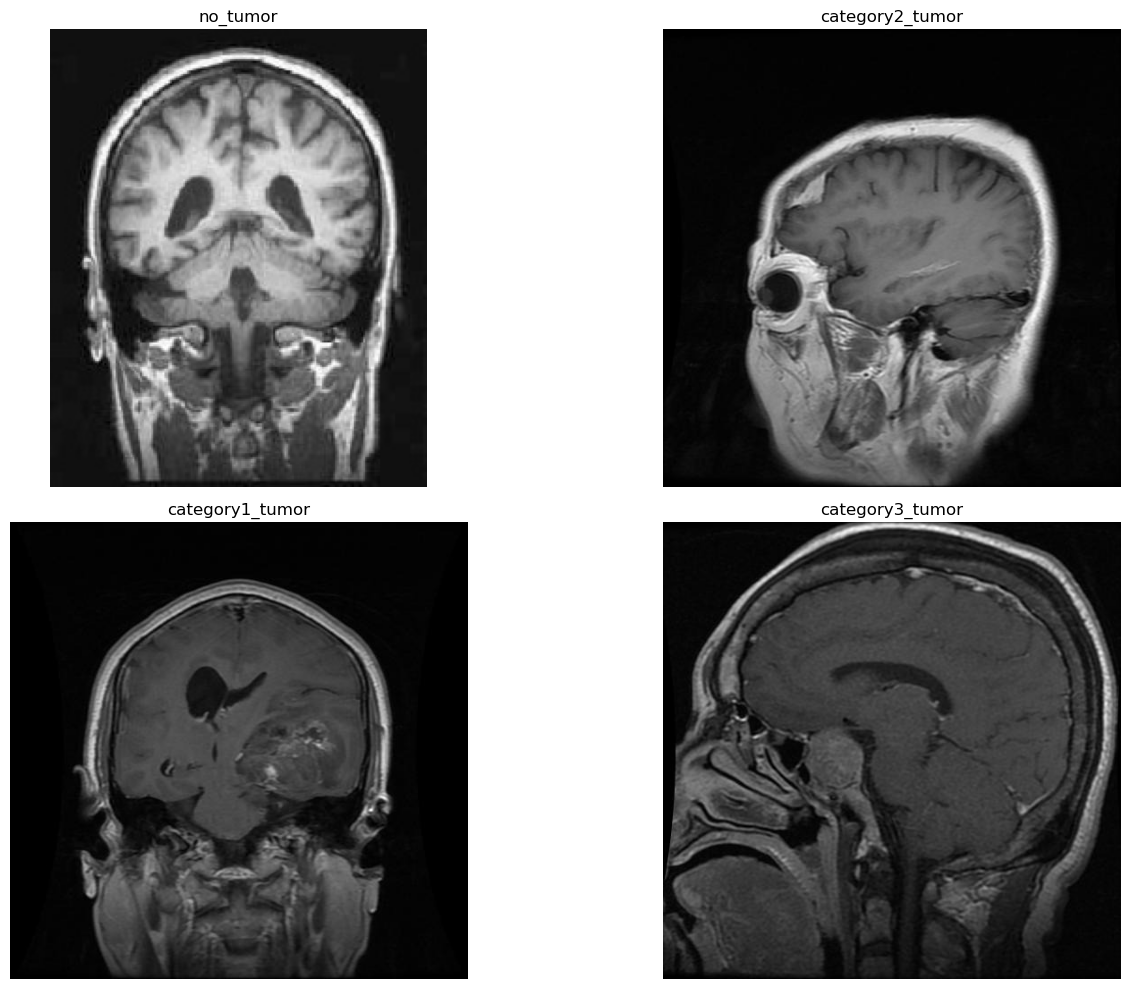

In [6]:
# Here we tryning to Display sample images from each class
plt.figure(figsize=(15, 10))
labels = os.listdir(train_dir)
for i, label in enumerate(labels):
    label_dir = os.path.join(train_dir, label)
    image_name = os.listdir(label_dir)[0]  # Select the first image
    image_path = os.path.join(label_dir, image_name)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Build the improved CNN model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3),
           kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),  
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(4, activation='softmax')
])


# Calculate class weights based on the class distribution
class_counts = np.bincount(y_train)
total_samples = np.sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}


# Compile the model
optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Convert target labels to one-hot encoded arrays
num_classes = len(labels)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Train the improved model with class weights
epochs = 250
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/250
72/72 [==============================] - 21s 89ms/step - loss: 5.1660 - accuracy: 0.4593 - val_loss: 34.2372 - val_accuracy: 0.1511 - lr: 0.0010
Epoch 2/250
72/72 [==============================] - 5s 65ms/step - loss: 4.6306 - accuracy: 0.5446 - val_loss: 9.2905 - val_accuracy: 0.2355 - lr: 0.0010
Epoch 3/250
72/72 [==============================] - 5s 65ms/step - loss: 4.0722 - accuracy: 0.6022 - val_loss: 4.0468 - val_accuracy: 0.4745 - lr: 0.0010
Epoch 4/250
72/72 [==============================] - 5s 69ms/step - loss: 3.5816 - accuracy: 0.6484 - val_loss: 7.2338 - val_accuracy: 0.3076 - lr: 0.0010
Epoch 5/250
72/72 [==============================] - 5s 66ms/step - loss: 3.0856 - accuracy: 0.6879 - val_loss: 3.7737 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 6/250
72/72 [==============================] - 5s 70ms/step - loss: 2.6770 - accuracy: 0.7138 - val_loss: 5.0516 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 7/250
72/72 [==============================] - 5s 68ms/step - 

In [8]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

12/12 [==============================] - 1s 67ms/step - loss: 1.4005 - accuracy: 0.7605
Test accuracy: 0.7605262994766235


In [9]:
from sklearn.metrics import classification_report

# Get predictions from the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Compute classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=labels)

# Print the classification report
print(report)


12/12 [==============================] - 0s 16ms/step
                 precision    recall  f1-score   support

       no_tumor       0.72      0.48      0.57       101
category2_tumor       0.65      0.76      0.70       101
category1_tumor       0.90      0.90      0.90       102
category3_tumor       0.77      0.95      0.85        76

       accuracy                           0.76       380
      macro avg       0.76      0.77      0.76       380
   weighted avg       0.76      0.76      0.75       380



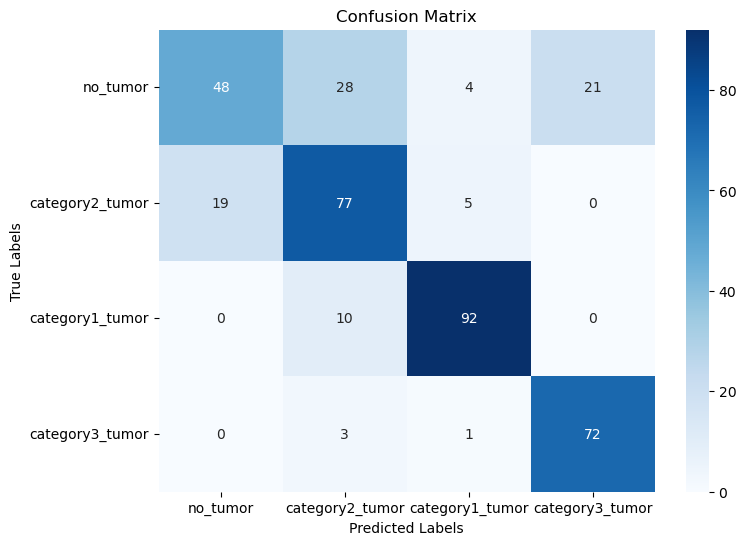

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Create a heatmap with values
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# Save the model
model.save('v5_model.h5')

12/12 [==============================] - 0s 16ms/step


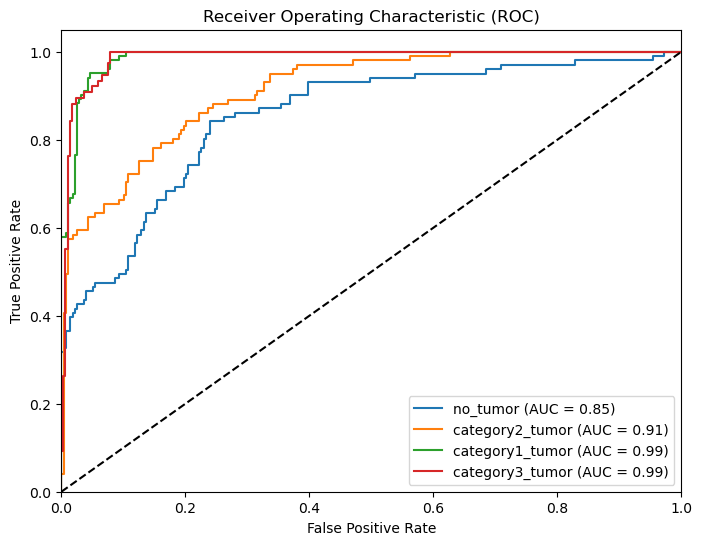

In [12]:
from sklearn.metrics import roc_curve, auc

# Get model prediction probabilities for each class
y_pred_probs = model.predict(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


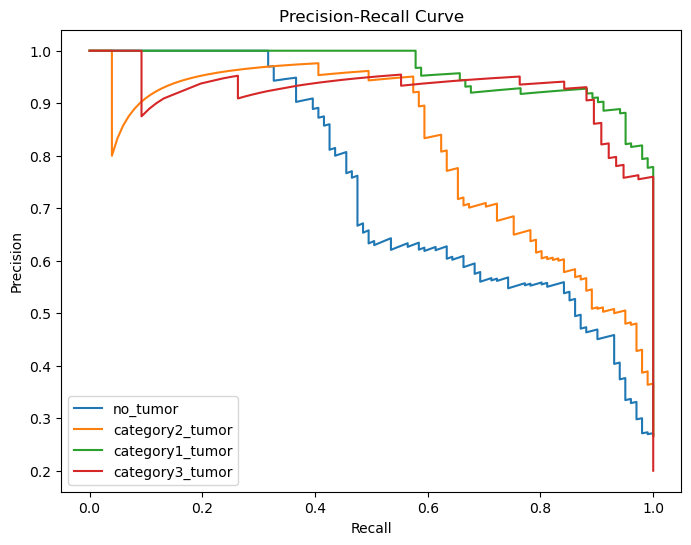

In [13]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve and area under PR curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'{labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


12/12 [==============================] - 0s 16ms/step


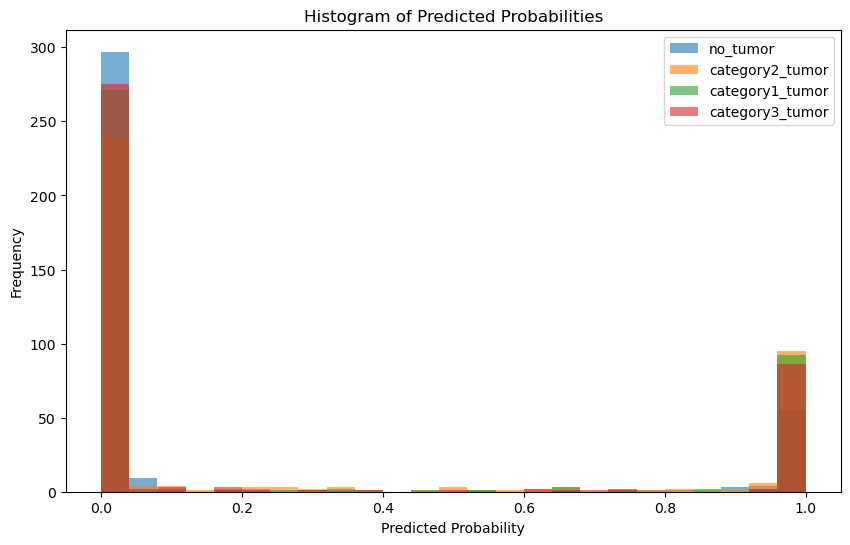

In [14]:
# Calculate predicted probabilities
y_pred_probs = model.predict(X_test)

# Plot histogram of predicted probabilities
plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    plt.hist(y_pred_probs[:, i], bins=25, alpha=0.6, label=labels[i])

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.legend()
plt.show()

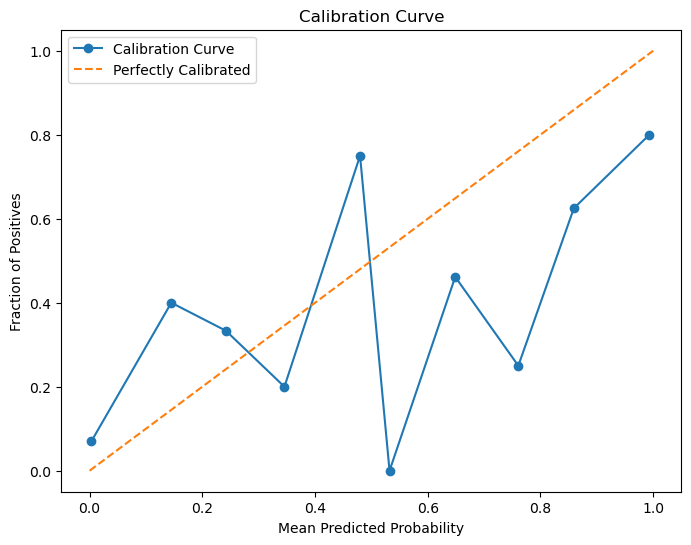

In [15]:
from sklearn.calibration import calibration_curve

# Calculate reliability curve
prob_true, prob_pred = calibration_curve(y_test.ravel(), y_pred_probs.ravel(), n_bins=10)

# Plot reliability curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()


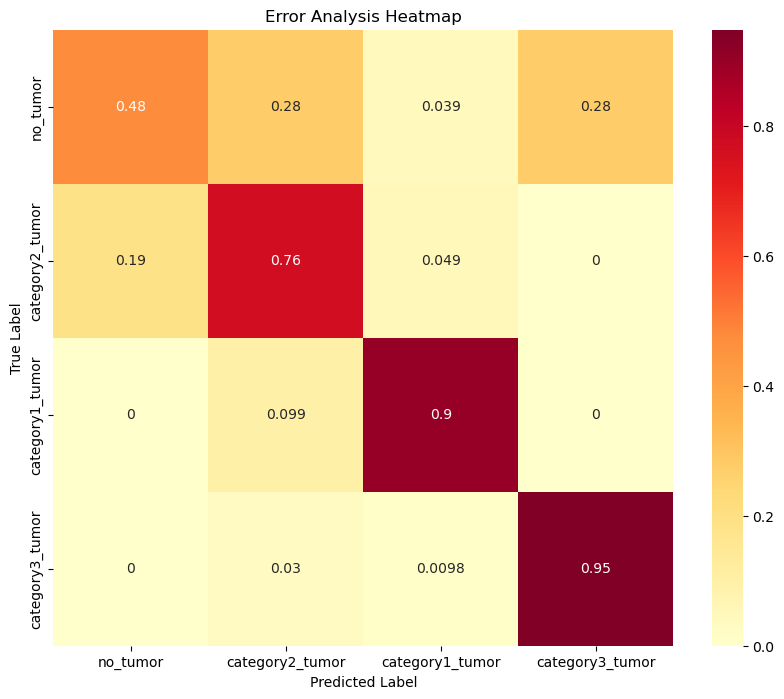

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate predicted classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Create error matrix
error_matrix = np.zeros((len(labels), len(labels)))
for true_label in range(len(labels)):
    for pred_label in range(len(labels)):
        error_matrix[true_label, pred_label] = np.sum((y_test[:, true_label] == 1) & (y_pred_classes == pred_label))

# Normalize error matrix
error_matrix = error_matrix / np.sum(y_test, axis=0, keepdims=True)

# Plot error matrix
plt.figure(figsize=(10, 8))
sns.heatmap(error_matrix, annot=True, cmap='YlOrRd', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Error Analysis Heatmap')
plt.show()


12/12 [==============================] - 0s 16ms/step


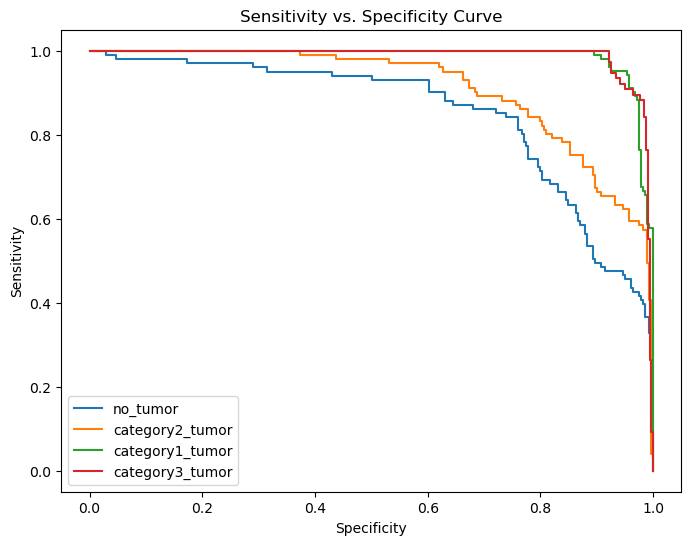

In [17]:
from sklearn.metrics import roc_curve, auc

# Get model prediction probabilities for each class
y_pred_probs = model.predict(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    specificity = 1 - fpr
    plt.plot(specificity, tpr, label=f'{labels[i]}')

plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity vs. Specificity Curve')
plt.legend()
plt.show()

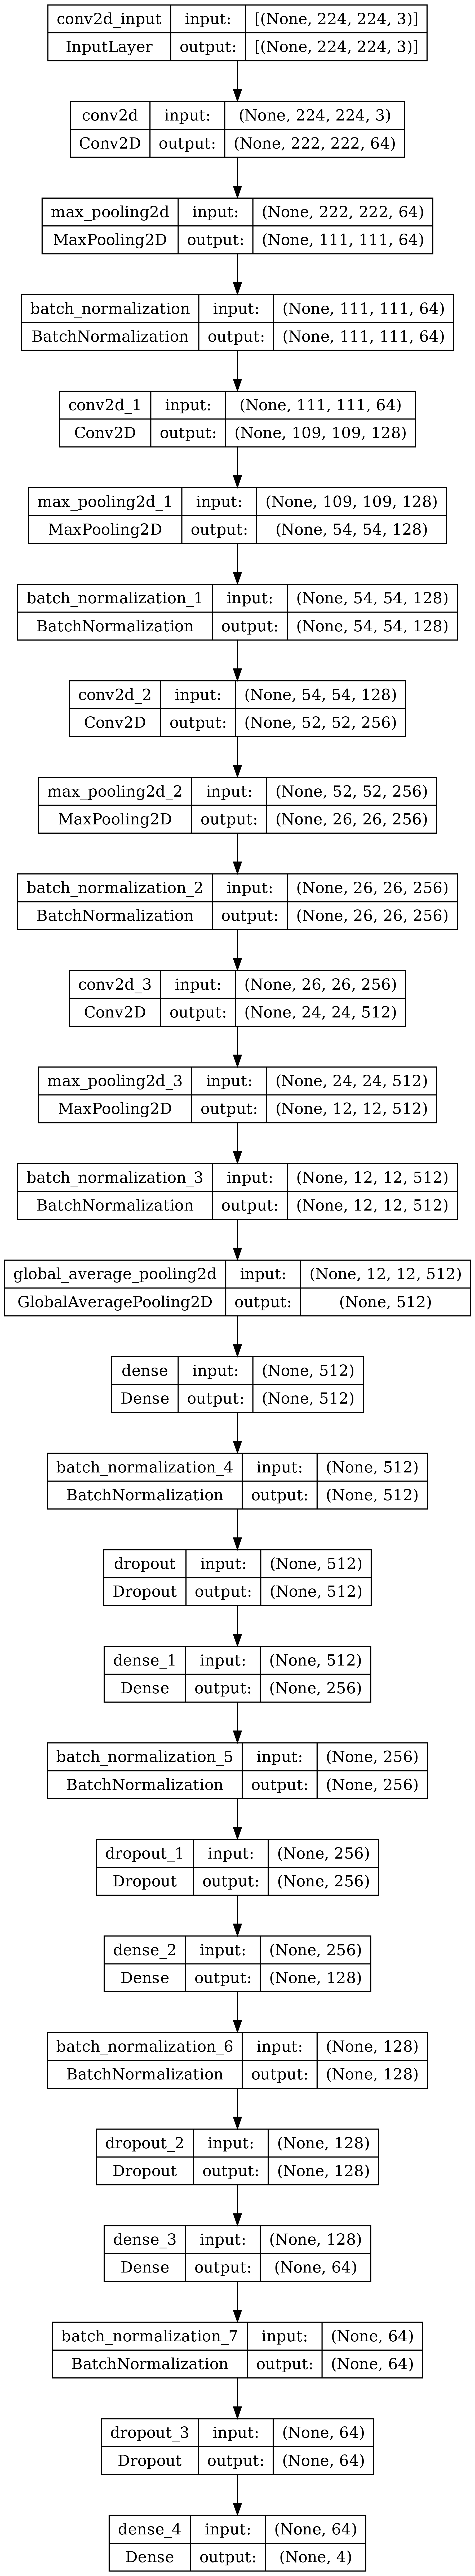

In [18]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import pydot

# ... (your code to create and compile the model)

# Create an instance of the model architecture
arch_model = Model(inputs=model.input, outputs=model.output)

# Plot the model architecture with more detailed plot using pydot
plot_model(arch_model, to_file='detailed_model_architecture.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=300, rankdir='TB')
